In [24]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Data 

In [26]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path,transform=image_transforms)

len(dataset)

2300

In [28]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [29]:
num_classes = len(dataset.classes)
num_classes

6

In [30]:

train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size,val_size

(1725, 575)

In [31]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [33]:
for images,labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [34]:
type(images), type(labels) , type(images[0]), type(labels[0]) , type(train_dataset), type(train_loader)

(torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.utils.data.dataset.Subset,
 torch.utils.data.dataloader.DataLoader)

In [35]:
images[0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.0494, -2.0665, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.0837, -2.1008, -2.1179],
         [-2.0323, -1.9809, -2.0152,  ..., -1.8782, -2.0837, -2.1179],
         ...,
         [-2.1179, -1.4843, -0.2513,  ..., -1.9809, -1.9638, -1.9638],
         [-2.1179, -1.5185, -0.3027,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -1.5014, -0.3027,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -1.8256, -1.9132, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -1.9832, -2.0007, -2.0357],
         [-1.9307, -1.8957, -1.9132,  ..., -1.8256, -2.0007, -2.0357],
         ...,
         [-2.0357, -1.4755, -0.3550,  ..., -1.8957, -1.8957, -1.8957],
         [-2.0357, -1.4930, -0.3901,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -1.4755, -0.3901,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.6127, -1.6824, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [36]:
labels[0]

tensor(5)

In [37]:
images[0].shape

torch.Size([3, 224, 224])

In [38]:
images[0].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


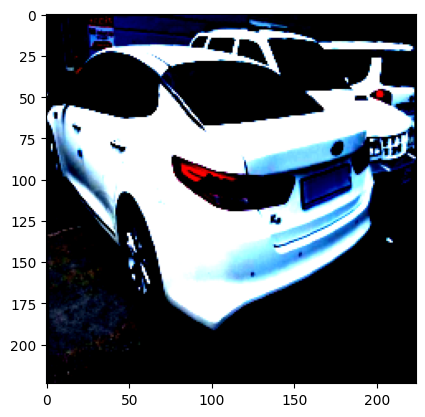

In [39]:
plt.imshow(images[0].permute(1, 2, 0))


plt.show()

## Model 1: CNN

In [40]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [41]:
images.size(0)

32

In [42]:
len(train_loader.dataset)

1725

In [43]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [44]:
values, indices = torch.max(torch.tensor([[10,12,15,9,2]]),1)
values, indices

(tensor([15]), tensor([2]))

In [45]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.82
Batch: 20, Epoch: 1, Loss: 1.80
Batch: 30, Epoch: 1, Loss: 1.81
Batch: 40, Epoch: 1, Loss: 1.77
Batch: 50, Epoch: 1, Loss: 1.72
Epoch [1/10], Avg Loss: 1.9419
*** Validation Accuracy: 34.26% ***
Batch: 10, Epoch: 2, Loss: 1.42
Batch: 20, Epoch: 2, Loss: 1.44
Batch: 30, Epoch: 2, Loss: 1.69
Batch: 40, Epoch: 2, Loss: 1.30
Batch: 50, Epoch: 2, Loss: 1.66
Epoch [2/10], Avg Loss: 1.5129
*** Validation Accuracy: 37.04% ***
Batch: 10, Epoch: 3, Loss: 1.49
Batch: 20, Epoch: 3, Loss: 1.28
Batch: 30, Epoch: 3, Loss: 1.29
Batch: 40, Epoch: 3, Loss: 1.28
Batch: 50, Epoch: 3, Loss: 1.18
Epoch [3/10], Avg Loss: 1.2747
*** Validation Accuracy: 44.70% ***
Batch: 10, Epoch: 4, Loss: 1.32
Batch: 20, Epoch: 4, Loss: 1.29
Batch: 30, Epoch: 4, Loss: 0.96
Batch: 40, Epoch: 4, Loss: 1.15
Batch: 50, Epoch: 4, Loss: 0.85
Epoch [4/10], Avg Loss: 1.0862
*** Validation Accuracy: 49.04% ***
Batch: 10, Epoch: 5, Loss: 1.09
Batch: 20, Epoch: 5, Loss: 1.00
Batch: 30, Epoch: 5, Loss: 1